## HW3: Classify the Digits Data Set Using Principal Component Analysis

Blanca Miller
<br>
STAT 760 
<br>
02/15/2018

__Objective:__ Using the MNIST data set, reduce the dimensionality of the training data using eigenvalues and classify the test data according to the chosen features. This approach is called principal component analysis (pca). Decomposing a multivariate data set using a set of orthogonal components (eigenvalues) allows the maximum information about the data to be held, while simplifying & generalizing the model for test data. After reducing the dimensionality of the data set, the Mahalanobis distance is used to classify the testing data set. The Mahalanobis Distance provides a means of computing the corresponding probability for each data point and every class in the set.   

## STEPS
1. Import librabries
2. Import data sets
3. Standardize data
4. Run PCA to choose max components and reduce the data's dimensionality
5. Compute mean and standard deviation for each class
6. Plot the gaussian distribution for each class
7. Use Mahalanobis' Distance to compute the probability of test data being in each class

## Data Set
- Each data point is an 8x8 image of a digit
- 10 classes compose the target set 
- ~180 samples per class
- 1797 total samples 
- Data set integers: 0-16

## Functions
- Compute the mean
- Compute the sample covariance matrix
- Evaluate the model using the Mahalanobis distance 

## Imports

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from scipy.spatial.distance import mahalanobis

## Import Digits Training & Testing Data Sets

In [2]:
# Load the data set
digits = datasets.load_digits()

# Training data set
X_digits = digits.data

# Target data set 
y_digits = digits.target

# Allocate 2/3 of the data set as training & 1/3 as testing
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.33)

# Print size of data subsets to verify splitting
print("Digits data set: {}".format(digits.data.shape))
print("X_train data set: {}".format(X_train.shape))
print("y_train target array: {}".format(y_train.shape))
print("X_test data set: {}".format(X_test.shape))
print("y_test target array: {}".format(y_test.shape))

Digits data set: (1797, 64)
X_train data set: (1203, 64)
y_train target array: (1203,)
X_test data set: (594, 64)
y_test target array: (594,)


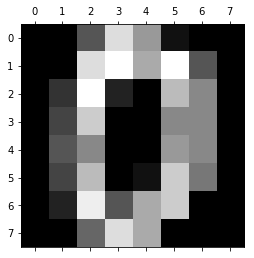

In [3]:
# Print digits data point to verify data loading
plt.gray()
plt.matshow(digits.images[0])
plt.show()

## Standardize Data

In [4]:
# Standardize trainging set to equally weight each component 
# Set axis to 1 to standardize per sample/vector rather than standardize each feature
X_train = preprocessing.scale(X_train, axis=1)
X_test = preprocessing.scale(X_test, axis=1)
print(X_train)

[[-0.77813144 -0.77813144 -0.77813144 ...,  2.07780616  0.11434906
  -0.77813144]
 [-0.71271935 -0.19827531  1.85950086 ..., -0.71271935 -0.71271935
  -0.71271935]
 [-0.83018435 -0.83018435 -0.83018435 ...,  0.50287153 -0.83018435
  -0.83018435]
 ..., 
 [-0.80469474 -0.80469474 -0.29646648 ..., -0.80469474 -0.80469474
  -0.80469474]
 [-0.81702415 -0.81702415 -0.81702415 ...,  1.03721505 -0.81702415
  -0.81702415]
 [-0.7706927  -0.7706927  -0.7706927  ...,  1.13975682 -0.59701547
  -0.7706927 ]]


## Function: Compute the Mean

In [5]:
def mean(features, targets, n_label):
    counter = 0
    n_avg = np.zeros_like(features[0])
    
    # loop through labels matrix to find all instances of n_label
    for i in range(features.shape[0]):
        
        if targets[i] == n_label:
            
            # sum the values for the ith row to the average vector
            n_avg += features[i]
            
            # count the number of instances of the n_label 
            counter += 1
    
    # divide the vector by the number of total n_labels
    n_avg /= counter
    
    return n_avg

## Function: Compute the Sample Covariance Matrix

$Q = \frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})(x_i - \bar{x})^T$

In [6]:
def cov(features, targets, n_label):
    counter = 0
    covariance = np.zeros((features.shape[1],features.shape[1]))
    
    for i in range(features.shape[0]):
        if targets[i] == n_label:
            
            # sum the n_label values & multiply the data by its transpose 
            # because we standardized the data, we don't subtract the mean
            covariance += np.outer(features[i], features[i])
            counter += 1     
                             
    return covariance * (1.0 / (counter-1.0))

## Function: Evaluate the Model

In [7]:
def eval_model(k, X_train, y_train, X_test, y_test):
    
    # Construct object representing PCA operation, executed by "fit" method: 
    # argument specifies the number of principal components to reduce data to
    pca = decomposition.PCA(n_components = k)
    
    # Execute PCA: identifies n components 
    pca.fit(X_train)
    
    # Project data: n dimensional reduced representation
    X_train_trans = pca.transform(X_train)
    X_test_trans = pca.transform(X_test)
    
    # compute the mean for each class/target
    mus = [mean(X_train_trans, y_train, n_label) for n_label in range(10)]
    
    # compute the sample covariance matrix for each class/target 
    sigmas = [cov(X_train_trans, y_train, n_label) for n_label in range(10)]    
    
    # compute the predicted response for the test set using the mahalanobis distance 
    y_hats = np.zeros(X_test_trans.shape[0])
    
    # loop through each test vector
    for i in range(X_test_trans.shape[0]): 
        distance = np.inf
        index = -1
        
        # loop through each class/target for each test vector
        for j in range(10):
            d = mahalanobis(X_test_trans[i], mus[j], sigmas[j])
            if d < distance:
                distance = d
                index = j
                
        # array of predictions
        y_hats[i] = index
    
    # compute rss for classification model on test set
    return (1.0/X_test_trans.shape[0]) * np.sqrt(np.sum((y_test - y_hats) ** 2))

## Evaluate Model

In [8]:
rsses = np.zeros(64)
error = np.inf
index = -1
for k in range(1, 64):
    rsses[k] = eval_model(k, X_train, y_train, X_test, y_test)
    if rsses[k] < error:
        error = rsses[k]
        index = k
print("Minimum Error Dimensionality: {}".format(index))

Minimum Error Dimensionality: 11


(63,)


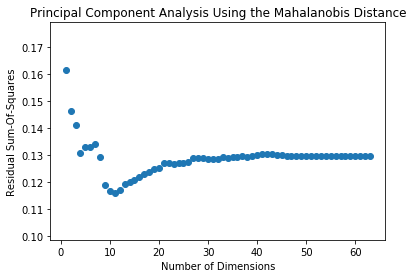

In [9]:
# graph scatter plot
x = range(1,64)
y = rsses[1:]

print(y.shape)

plt.scatter(x,y)
plt.title("Principal Component Analysis Using the Mahalanobis Distance")
plt.xlabel("Number of Dimensions")
plt.ylabel("Residual Sum-Of-Squares")
plt.show()